## Comparing with a numerical scheme

The Poisson equation is possible to solve using Taylor series to approximate the second derivative.

Using Taylor series, the second derivative can be expressed as
g′′(x)=g(x+Δx)−2g(x)+g(x−Δx)Δx2+EΔx(x)

where Δx
is a small step size and EΔx(x)

being the error term.

Looking away from the error terms gives an approximation to the second derivative:
g′′(x)≈g(x+Δx)−2g(x)+g(x−Δx)Δx2(15)

If xi=iΔx=xi−1+Δx
and gi=g(xi) for i=1,…Nx−2 with Nx being the number of values for x, (15) becomes
g′′(xi)≈g(xi+Δx)−2g(xi)+g(xi−Δx)Δx2=gi+1−2gi+gi−1Δx2

Since we know from our problem that
−g′′(x)=f(x)=(3x+x2)exp(x)

along with the conditions g(0)=g(1)=0
, the following scheme can be used to find an approximate solution for g(x) numerically:
−(gi+1−2gi+gi−1Δx2)−gi+1+2gi−gi−1=f(xi)=Δx2f(xi)(16)

for i=1,…,Nx−2
where g0=gNx−1=0 and f(xi)=(3xi+x2i)exp(xi)

, which is given for our specific problem.

The equation can be rewritten into a matrix equation:
⎛⎝⎜⎜⎜⎜⎜⎜⎜2−1⋮00−12……0−1⋱−10……2−100⋮−12⎞⎠⎟⎟⎟⎟⎟⎟⎟⎛⎝⎜⎜⎜⎜⎜⎜⎜g1g2⋮gNx−3gNx−2⎞⎠⎟⎟⎟⎟⎟⎟⎟Ag⃗ =Δx2⎛⎝⎜⎜⎜⎜⎜⎜⎜f(x1)f(x2)⋮f(xNx−3)f(xNx−2)⎞⎠⎟⎟⎟⎟⎟⎟⎟=f⃗ 

which makes it possible to solve for the vector g⃗ 

.

We can then compare the result from this numerical scheme with the output from our network using Autograd: 

https://compphysics.github.io/MachineLearning/doc/pub/odenn/html/._odenn-bs025.html

C:\Users\KarlH\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Initial cost: 457.256
Final cost: 0.00310113
The max absolute difference between the analytical solution and DNN Autograd: 0.000464088
The max absolute difference between the analytical solution and numerical scheme: 0.00266858


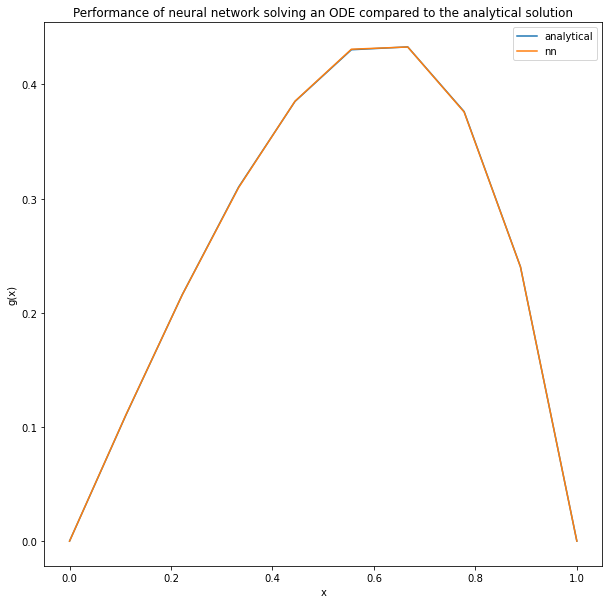

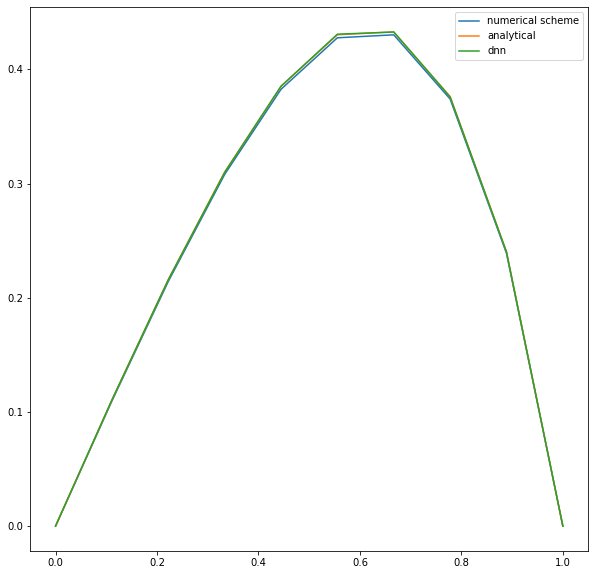

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from matplotlib import pyplot as plt

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # N_hidden is the number of hidden layers
    N_hidden = np.size(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assumes input x being an one-dimensional array
    num_values = np.size(x)
    x = x.reshape(-1, num_values)

    # Assume that the input layer does nothing to the input x
    x_input = x

    # Due to multiple hidden layers, define a variable referencing to the
    # output of the previous layer:
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_values)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_values)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output

def solve_ode_deep_neural_network(x, num_neurons, num_iter, lmb):
    # num_hidden_neurons is now a list of number of neurons within each hidden layer

    # Find the number of hidden layers:
    N_hidden = np.size(num_neurons)

    ## Set up initial weigths and biases

    # Initialize the list of parameters:
    P = [None]*(N_hidden + 1) # + 1 to include the output layer

    P[0] = npr.randn(num_neurons[0], 2 )
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) # +1 to include bias

    # For the output layer
    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) # +1 since bias is included

    print('Initial cost: %g'%cost_function_deep(P, x))

    ## Start finding the optimal weigths using gradient descent

    # Find the Python function that represents the gradient of the cost function
    # w.r.t the 0-th input argument -- that is the weights and biases in the hidden and output layer
    cost_function_deep_grad = grad(cost_function_deep,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        # Evaluate the gradient at the current weights and biases in P.
        # The cost_grad consist now of N_hidden + 1 arrays; the gradient w.r.t the weights and biases
        # in the hidden layers and output layers evaluated at x.
        cost_deep_grad =  cost_function_deep_grad(P, x)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_deep_grad[l]

    print('Final cost: %g'%cost_function_deep(P, x))

    return P

## Set up the cost function specified for this Poisson equation:

# The right side of the ODE
def f(x):
    return (3*x + x**2)*np.exp(x)

def cost_function_deep(P, x):

    # Evaluate the trial function with the current parameters P
    g_t = g_trial_deep(x,P)

    # Find the derivative w.r.t x of the trial function
    d2_g_t = elementwise_grad(elementwise_grad(g_trial_deep,0))(x,P)

    right_side = f(x)

    err_sqr = (-d2_g_t - right_side)**2
    cost_sum = np.sum(err_sqr)

    return cost_sum/np.size(err_sqr)

# The trial solution:
def g_trial_deep(x,P):
    return x*(1-x)*deep_neural_network(P,x)

# The analytic solution;
def g_analytic(x):
    return x*(1-x)*np.exp(x)

if __name__ == '__main__':
    npr.seed(4155)

    ## Decide the vales of arguments to the function to solve
    Nx = 10
    x = np.linspace(0,1, Nx)

    ## Set up the initial parameters
    num_hidden_neurons = [200,100]
    num_iter = 1000
    lmb = 1e-3

    P = solve_ode_deep_neural_network(x, num_hidden_neurons, num_iter, lmb)

    g_dnn_ag = g_trial_deep(x,P)
    g_analytical = g_analytic(x)

    # Find the maximum absolute difference between the solutons:

    plt.figure(figsize=(10,10))

    plt.title('Performance of neural network solving an ODE compared to the analytical solution')
    plt.plot(x, g_analytical)
    plt.plot(x, g_dnn_ag[0,:])
    plt.legend(['analytical','nn'])
    plt.xlabel('x')
    plt.ylabel('g(x)')

    ## Perform the computation using the numerical scheme

    dx = 1/(Nx - 1)

    # Set up the matrix A
    A = np.zeros((Nx-2,Nx-2))

    A[0,0] = 2
    A[0,1] = -1

    for i in range(1,Nx-3):
        A[i,i-1] = -1
        A[i,i] = 2
        A[i,i+1] = -1

    A[Nx - 3, Nx - 4] = -1
    A[Nx - 3, Nx - 3] = 2

    # Set up the vector f
    f_vec = dx**2 * f(x[1:-1])

    # Solve the equation
    g_res = np.linalg.solve(A,f_vec)

    g_vec = np.zeros(Nx)
    g_vec[1:-1] = g_res

    # Print the differences between each method
    max_diff1 = np.max(np.abs(g_dnn_ag - g_analytical))
    max_diff2 = np.max(np.abs(g_vec - g_analytical))
    print("The max absolute difference between the analytical solution and DNN Autograd: %g"%max_diff1)
    print("The max absolute difference between the analytical solution and numerical scheme: %g"%max_diff2)

    # Plot the results
    plt.figure(figsize=(10,10))

    plt.plot(x,g_vec)
    plt.plot(x,g_analytical)
    plt.plot(x,g_dnn_ag[0,:])

    plt.legend(['numerical scheme','analytical','dnn'])
    plt.show()